In [41]:
%load_ext autoreload
%autoreload 2

import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from albumentations import *
from torchvision import transforms
from torch.utils.data import DataLoader
from glob import glob
import segmentation_models_pytorch as smp

import torch.nn as nn 
import torch.nn.functional as F
from tqdm import tqdm 

import wandb
import logging
from tqdm import tqdm

# load dataset 
import RS_dataset
import RS_utils
import RS_models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
#-- data
img_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/01.512_imgs"
mask_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/02.512_masks"

img_path_ship  = np.array(sorted(glob(os.path.join(img_path, "*.png"))) )
mask_path_ship = np.array(sorted(glob(os.path.join(mask_path, "*.png"))) )

aa = np.load("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Training/Segmentation/03.data_list/512_ships.npy")

selected_paths_img = img_path_ship[aa]
selected_paths_mask  = mask_path_ship[aa]

#-- category 
ISAID_CLASSES_SHIP = (
    'background','ship','harbor' 
    )
ISAID_PALETTE_SHIP = {
    0: (0, 0, 0), 
    1: (0, 0, 63), 
    2: (0, 100, 155)}

In [43]:
dataset = RS_dataset.Seg_RS_dataset_ship(img_dir=selected_paths_img, mask_dir=selected_paths_mask, image_resize = None, phase="train",palette=ISAID_PALETTE_SHIP )

In [44]:
rad_int = np.random.randint(0,400)
print(rad_int)
img, mask = dataset.__getitem__(rad_int)

245


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


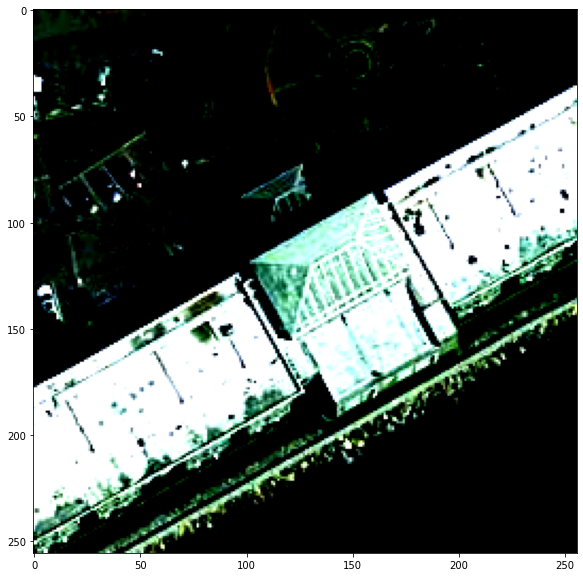

In [45]:
RS_utils.torch_display(img)

In [46]:
mask.shape

torch.Size([256, 256])

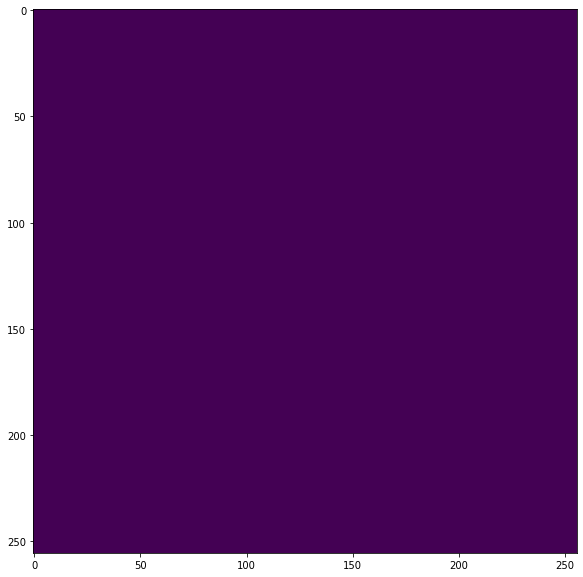

In [47]:
RS_utils.torch_display_mask(mask)

In [48]:
model = smp.UnetPlusPlus(
    encoder_name="resnet152",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)


aa = "./02.ckpts"

w_path = sorted(glob(os.path.join(aa, "*.pt")))[-1]
print(w_path)
weights_ = torch.load(w_path, map_location=torch.device('cpu'))
model.load_state_dict(weights_)
model = model.eval()

./02.ckpts/ver_35_edgenet_epoch_81_iteration_377136.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


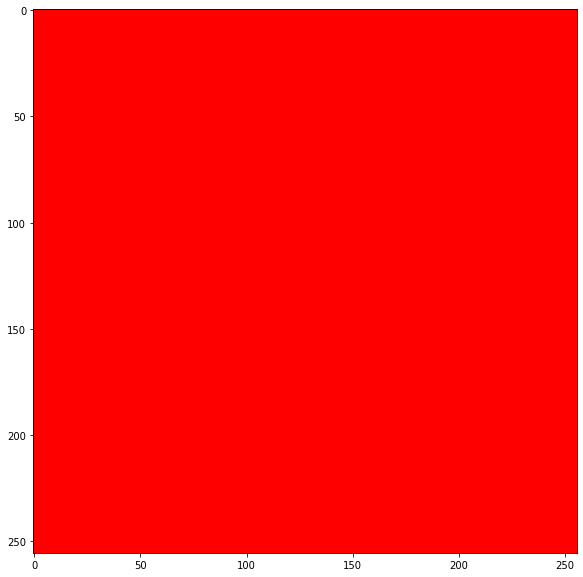

In [49]:
img_ = img.unsqueeze(0)
pred = model(img_)
static_pred = pred.clone()
pred_ = pred.squeeze(0)
pred_ = pred_.detach().cpu()

RS_utils.torch_display(pred_)

In [50]:
torch.mean(static_pred)

tensor(-0.7392, grad_fn=<MeanBackward0>)

In [53]:
torch.std(static_pred)

tensor(2.6149, grad_fn=<StdBackward0>)

In [54]:
static_pred.shape

torch.Size([1, 3, 256, 256])

In [55]:
soft_static_pred = torch.softmax( static_pred, dim=1)

In [56]:
torch.mean(soft_static_pred), torch.std(soft_static_pred)

(tensor(0.3333, grad_fn=<MeanBackward0>),
 tensor(0.4636, grad_fn=<StdBackward0>))

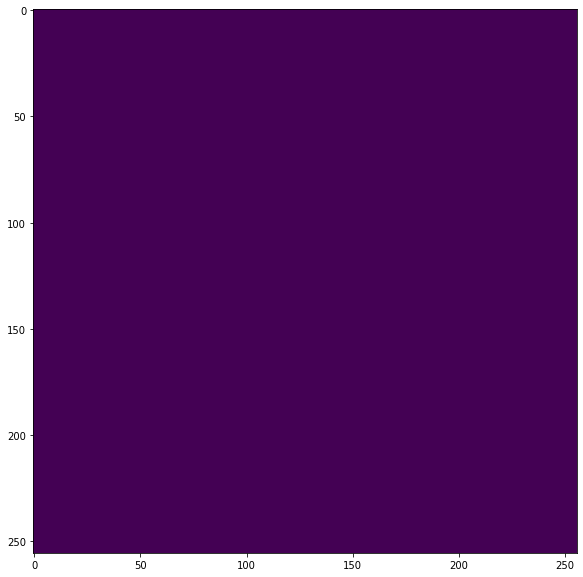

In [52]:
pred_mask = torch.argmax(pred, dim=1)
pred_mask.shape
RS_utils.torch_display(pred_mask)